# First GAN with MNIST - MNIST dataset

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Utilities

가짜 이미지를 그릴 수있는 도우미 기능. 훈련되는 동안 GAN의 샘플 출력을 시각화하는 데 사용됩니다.

In [2]:
# 가짜 이미지가 어떻게 형성되었는지 출력하는 함수
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Download and Prepare the Dataset

- MNIST 데이터세트로드
-  픽셀 값을 정규화하여이를 전처리

In [3]:
# load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


훈련하는 동안 모델에 공급할 수 있도록 훈련 이미지의 배치를 생성.

In [4]:
# 훈련하는 동안 모델에 공급할 수 있도록 훈련 이미지의 배치를 생성.
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
# drop_remainder : 딱 떨어지지 않는 나머지를 drop (60000 / 128 = 나머지가 존재하기 때문)

## Build the Model

이제 GAN의 두 가지 주요 부분을 만듭니다.
* 생성기 - 가짜 데이터 생성
* 판별 자 - 이미지가 가짜인지 실제인지 결정

Sequential API를 사용하여 Dense 레이어를 쌓아 이러한 하위 네트워크를 구축합니다.

### Generator

Generator는 임의의 노이즈를 받아 가짜 이미지를 만드는 데 사용합니다. 이를 위해 이 모델은 랜덤 노이즈 형태로 받아서 MNIST 데이터 세트 (예 : 28 x 28)와 동일한 크기의 이미지를 출력합니다.

[SELU](https://arxiv.org/abs/1706.02515)는 GAN에 적합한 활성화 함수로 확인되었으며 처음 두 개의 Dense 네트워크에서 이를 사용합니다. 최종 Dense 네트워크는 0과 1 사이의 픽셀 값을 생성하기 원하므로 sigmoid로 활성화됩니다. 그런 다음 MNIST 데이터 세트의 차원에 맞게 reshape 됩니다.

In [5]:
# declare shape of the noise input
# normal distribution을 만들 dimension을 32차원으로
random_normal_dimensions = 32

# generator model
# SELU : GAN에 적합한 활성화 함수로 ReLU 계열임 => 처음 두 개의 Dense 네트워크에서 사용
# sigmoid : 최종 Dense 네트워크는 0과 1 사이의 픽셀 값을 생성하기 원해서
generator = keras.models.Sequential([
    keras.layers.Dense(64, activation="selu", input_shape=[random_normal_dimensions]),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])  # 데이터 세트의 차원에 맞게 reshape
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


훈련되지 않은 generator의 샘플 출력을 보겠습니다. 예상대로 이것은 random point가 될 것입니다. 훈련 후에는 MNIST 데이터 세트의 숫자를 닮게 됩니다.

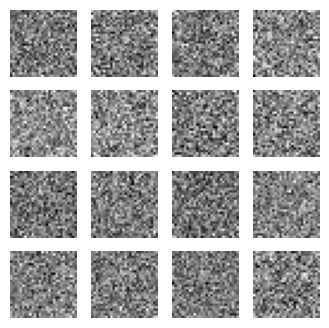

In [6]:
# 훈련되지 않은 generator의 샘플 출력 => random point 그 자체를 출력할 것
# 훈련 후 : MNIST 데이터 세트의 숫자를 닮을것
# batch size = 16로 노이즈 생성
test_noise = tf.random.normal([16, random_normal_dimensions])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_multiple_images(test_image, n_cols=4)

### Discriminator

판별자는 입력(가짜 또는 실제) 이미지를 가져와 가짜인지 아닌지를 결정합니다. 따라서 input shape은 훈련 이미지의 모양이 됩니다. 이것은 flatten 되어 dense network에 공급될 수 있으며 최종 출력은 0 (가짜)과 1 (실제) 사이의 값입니다.

generator와 마찬가지로 처음 두 개의 dense network에서 SELU 활성화를 사용하고 sigmoid로 final network를 활성화합니다.

In [7]:
# input shape = 훈련 이미지의 모양
# => flatten => dense network에 공급 => 출력 : 0 (가짜)과 1 (실제) 사이의 값
# build the discriminator model
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(128, activation="selu"), # 처음 두 개의 dense network에서 SELU 활성화
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid") # sigmoid로 final network를 활성화
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Generator, Discriminator 두 모델을 추가해 GAN 구축
gan = keras.models.Sequential([generator, discriminator])


## Configure Training Parameters

이제 훈련을 위해 모델을 준비합니다. 라벨이 0 (가짜) 또는 1 (실제)이 될 것으로 예상하기 때문에`binary_crossentropy`로 손실을 측정 할 수 있습니다.

In [9]:
# Configure Training Parameters
# binary_crossentropy로 손실 => 이유 : 라벨이 0 (가짜) 또는 1 (실제)이 될 것
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

다음으로 훈련 루프를 정의합니다. 이는 두 단계로 구성됩니다.

* 1 단계 - 가짜 데이터와 실제 데이터를 구분하도록 판별자를 훈련시킵니다.
* 2 단계 - 판별자를 속이는 이미지를 생성하도록 생성자를 훈련합니다.

각 epoch마다 생성자에 의해 생성되는 가짜 이미지를 확인하기 위해 이미지 샘플 갤러리를 표시합니다. 이러한 단계가 수행되는 방법에 대한 자세한 내용은 아래 코드 주석에 나와 있습니다.

In [10]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=100):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    # start loop
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset: # 데이터셋에서 실제 이미지를 읽어들임
            # 훈련 배치에서 배치 크기 추론
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # noise 생성
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # 노이즈를 사용하여 가짜 이미지 생성
            fake_images = generator(noise)

            # 가짜 이미지와 실제 이미지를 연결하여 list 만들기
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # discriminator를 위한 label 생성 (지도학습을 하기 위함)
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # Ensure that the discriminator is trainable
            discriminator.trainable = True

            # train_on_batch를 사용하여 mixed_images 와 discriminator_labels로 판별자를 훈련합니다.
            # 0을 0으로 맞추고, 1을 1로 맞춤 => 손실이 없음
            # 잘못 맞추면 backpropagation 될 것
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            # discriminator.fit(mixed_images, discriminator_labels) : fit == train_on_batch

            # Train the generator - PHASE 2
            # GAN에 공급할 노이즈 입력 배치 새롭게 생성
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # 생성된 모든 이미지에 "real" 레이블 지정
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator : 훈련된 감별자 고정
            discriminator.trainable = False

            # 레이블이 모두 true로 설정된 노이즈에 대한 GAN 훈련
            # generator의 출력이 discriminator의 입력으로 들어가, 1, 0 중 하나로 판단
            # discriminator가 속아서 1을 출력시, generator_labels과 동일하므로 손실이 0 => 성공!
            gan.train_on_batch(noise, generator_labels) # generator_labels = 1
            # gan.fit(noise, generator_labels)

        #판별자를 훈련하는 데 사용되는 가짜 이미지를 플로팅합니다.
        plot_multiple_images(fake_images, 8)
        plt.show()

출력 셀을 스크롤하여 에포크 당 가짜 이미지가 어떻게 개선되는지 확인할 수 있습니다.

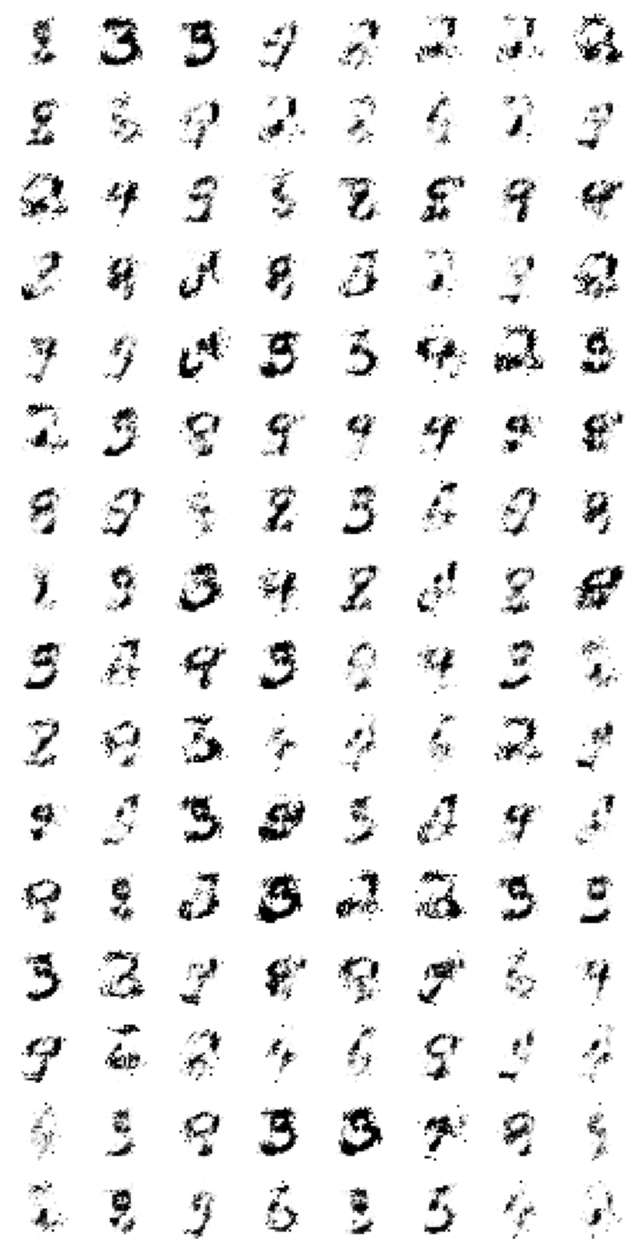

Epoch 7/30


In [ ]:
# 훈련
train_gan(gan, dataset, random_normal_dimensions, n_epochs=30)